#### Variable Description cheat sheet

Gender: None

Age: None

Height: None

Weight: None

family_history_with_overweight: Has a family member suffered or suffers from overweight?

FAVC: Do you eat high caloric food frequently?

FCVC: Do you usually eat vegetables in your meals?

NCP: How many main meals do you have daily?

CAEC: Do you eat any food between meals?

SMOKE: Do you smoke?

CH2O: How much water do you drink daily?

SCC: Do you monitor the calories you eat daily?

FAF: How often do you have physical activity?

TUE: How much time do you use technological devices such as cell phone, videogames, television computer and others?"

CALC: How often do you drink alcohol?

MTRANS: Which transportation do you usually use?

NObeyesdad: Obesity level



In [36]:
from scipy.stats import pearsonr
import numpy as np


def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes, color = "red", fontsize = 15)


def qq_plot(lm,save_path, kind="Residuals"):
    # Extract residuals from the linear model
    resid = lm.resid

    # Calculate the quantiles
    y = np.quantile(resid[~np.isnan(resid)], [0.25, 0.75])
    x = stats.norm.ppf([0.25, 0.75])

    # Calculate the slope and intercept for the Q-Q plot reference line
    slope = np.diff(y) / np.diff(x)
    intercept = y[0] - slope * x[0]

    # Create the Q-Q plot
    plt.figure(figsize=(8, 6))
    stats.probplot(resid, dist="norm", plot=plt)
    plt.plot(x, slope * x + intercept, color="blue", lw=2)

    # Customize the plot
    plt.title(f"{kind} Q-Q Plot")
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.savefig(save_path)

    plt.show()



#### Load The data

In [37]:
import pandas as pd
# df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")


In [38]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
# fetch dataset
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544)

# data (as pandas dataframes)
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets

df = pd.concat([X, y], axis=1)


# metadata
meta_data = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.metadata

# variable information
variables = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.variables



df["BMI"] = df["Weight"] / df["Height"]

continuous_vars = variables[(variables["type"] == "Continuous") |
                            (variables["type"] == "Integer")]["name"].to_list() + ["BMI"]


categorical_vars = variables[(variables["type"] == "Categorical") |
                            (variables["type"] == "Binary")]["name"].to_list()


#A few of the NCP values (number of meals per day) are long floats which doesnt make sence
#I rounded them and will treat as categorical vars since there are only 4 values
df["NCP"] = df["NCP"].astype(int).round()
continuous_vars.remove("NCP")
categorical_vars.append("NCP")

variables[["name","description"]]


,name,description
0,Gender,None
1,Age,None
2,Height,None
3,Weight,None
4,family_history_with_overweight,Has a family member suffered or suffers from o...
5,FAVC,Do you eat high caloric food frequently?
6,FCVC,Do you usually eat vegetables in your meals?
7,NCP,How many main meals do you have daily?
8,CAEC,Do you eat any food between meals?
9,SMOKE,Do you smoke?


#### Describe the continuous variables distribution

In [39]:
df[continuous_vars].describe()

,Age,Height,Weight,FCVC,CH2O,FAF,TUE,BMI
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.008011,1.010298,0.657866,50.638549
std,6.345968,0.093305,26.191172,0.533927,0.612953,0.850592,0.608927,14.265599
min,14.000000,1.450000,39.000000,1.000000,1.000000,0.000000,0.000000,23.788477
25%,19.947192,1.630000,65.473343,2.000000,1.584812,0.124505,0.000000,40.469309
50%,22.777890,1.700499,83.000000,2.385502,2.000000,1.000000,0.625350,49.376062
75%,26.000000,1.768464,107.430682,3.000000,2.477420,1.666678,1.000000,63.496039
max,61.000000,1.980000,173.000000,3.000000,3.000000,3.000000,2.000000,92.513369


#### Count the frequency of categorical varaibles

In [40]:
from pprint import pprint
cts = df.value_counts()
count_dict = {}
for v in categorical_vars:
    count_dict[v] = df[v].value_counts().to_dict() 

pprint(count_dict)

{'CAEC': {'Always': 53, 'Frequently': 242, 'Sometimes': 1765, 'no': 51},
 'CALC': {'Always': 1, 'Frequently': 70, 'Sometimes': 1401, 'no': 639},
 'FAVC': {'no': 245, 'yes': 1866},
 'Gender': {'Female': 1043, 'Male': 1068},
 'MTRANS': {'Automobile': 457,
            'Bike': 7,
            'Motorbike': 11,
            'Public_Transportation': 1580,
            'Walking': 56},
 'NCP': {1: 395, 2: 285, 3: 1362, 4: 69},
 'NObeyesdad': {'Insufficient_Weight': 272,
                'Normal_Weight': 287,
                'Obesity_Type_I': 351,
                'Obesity_Type_II': 297,
                'Obesity_Type_III': 324,
                'Overweight_Level_I': 290,
                'Overweight_Level_II': 290},
 'SCC': {'no': 2015, 'yes': 96},
 'SMOKE': {'no': 2067, 'yes': 44},
 'family_history_with_overweight': {'no': 385, 'yes': 1726}}


#### continuous scatter plots

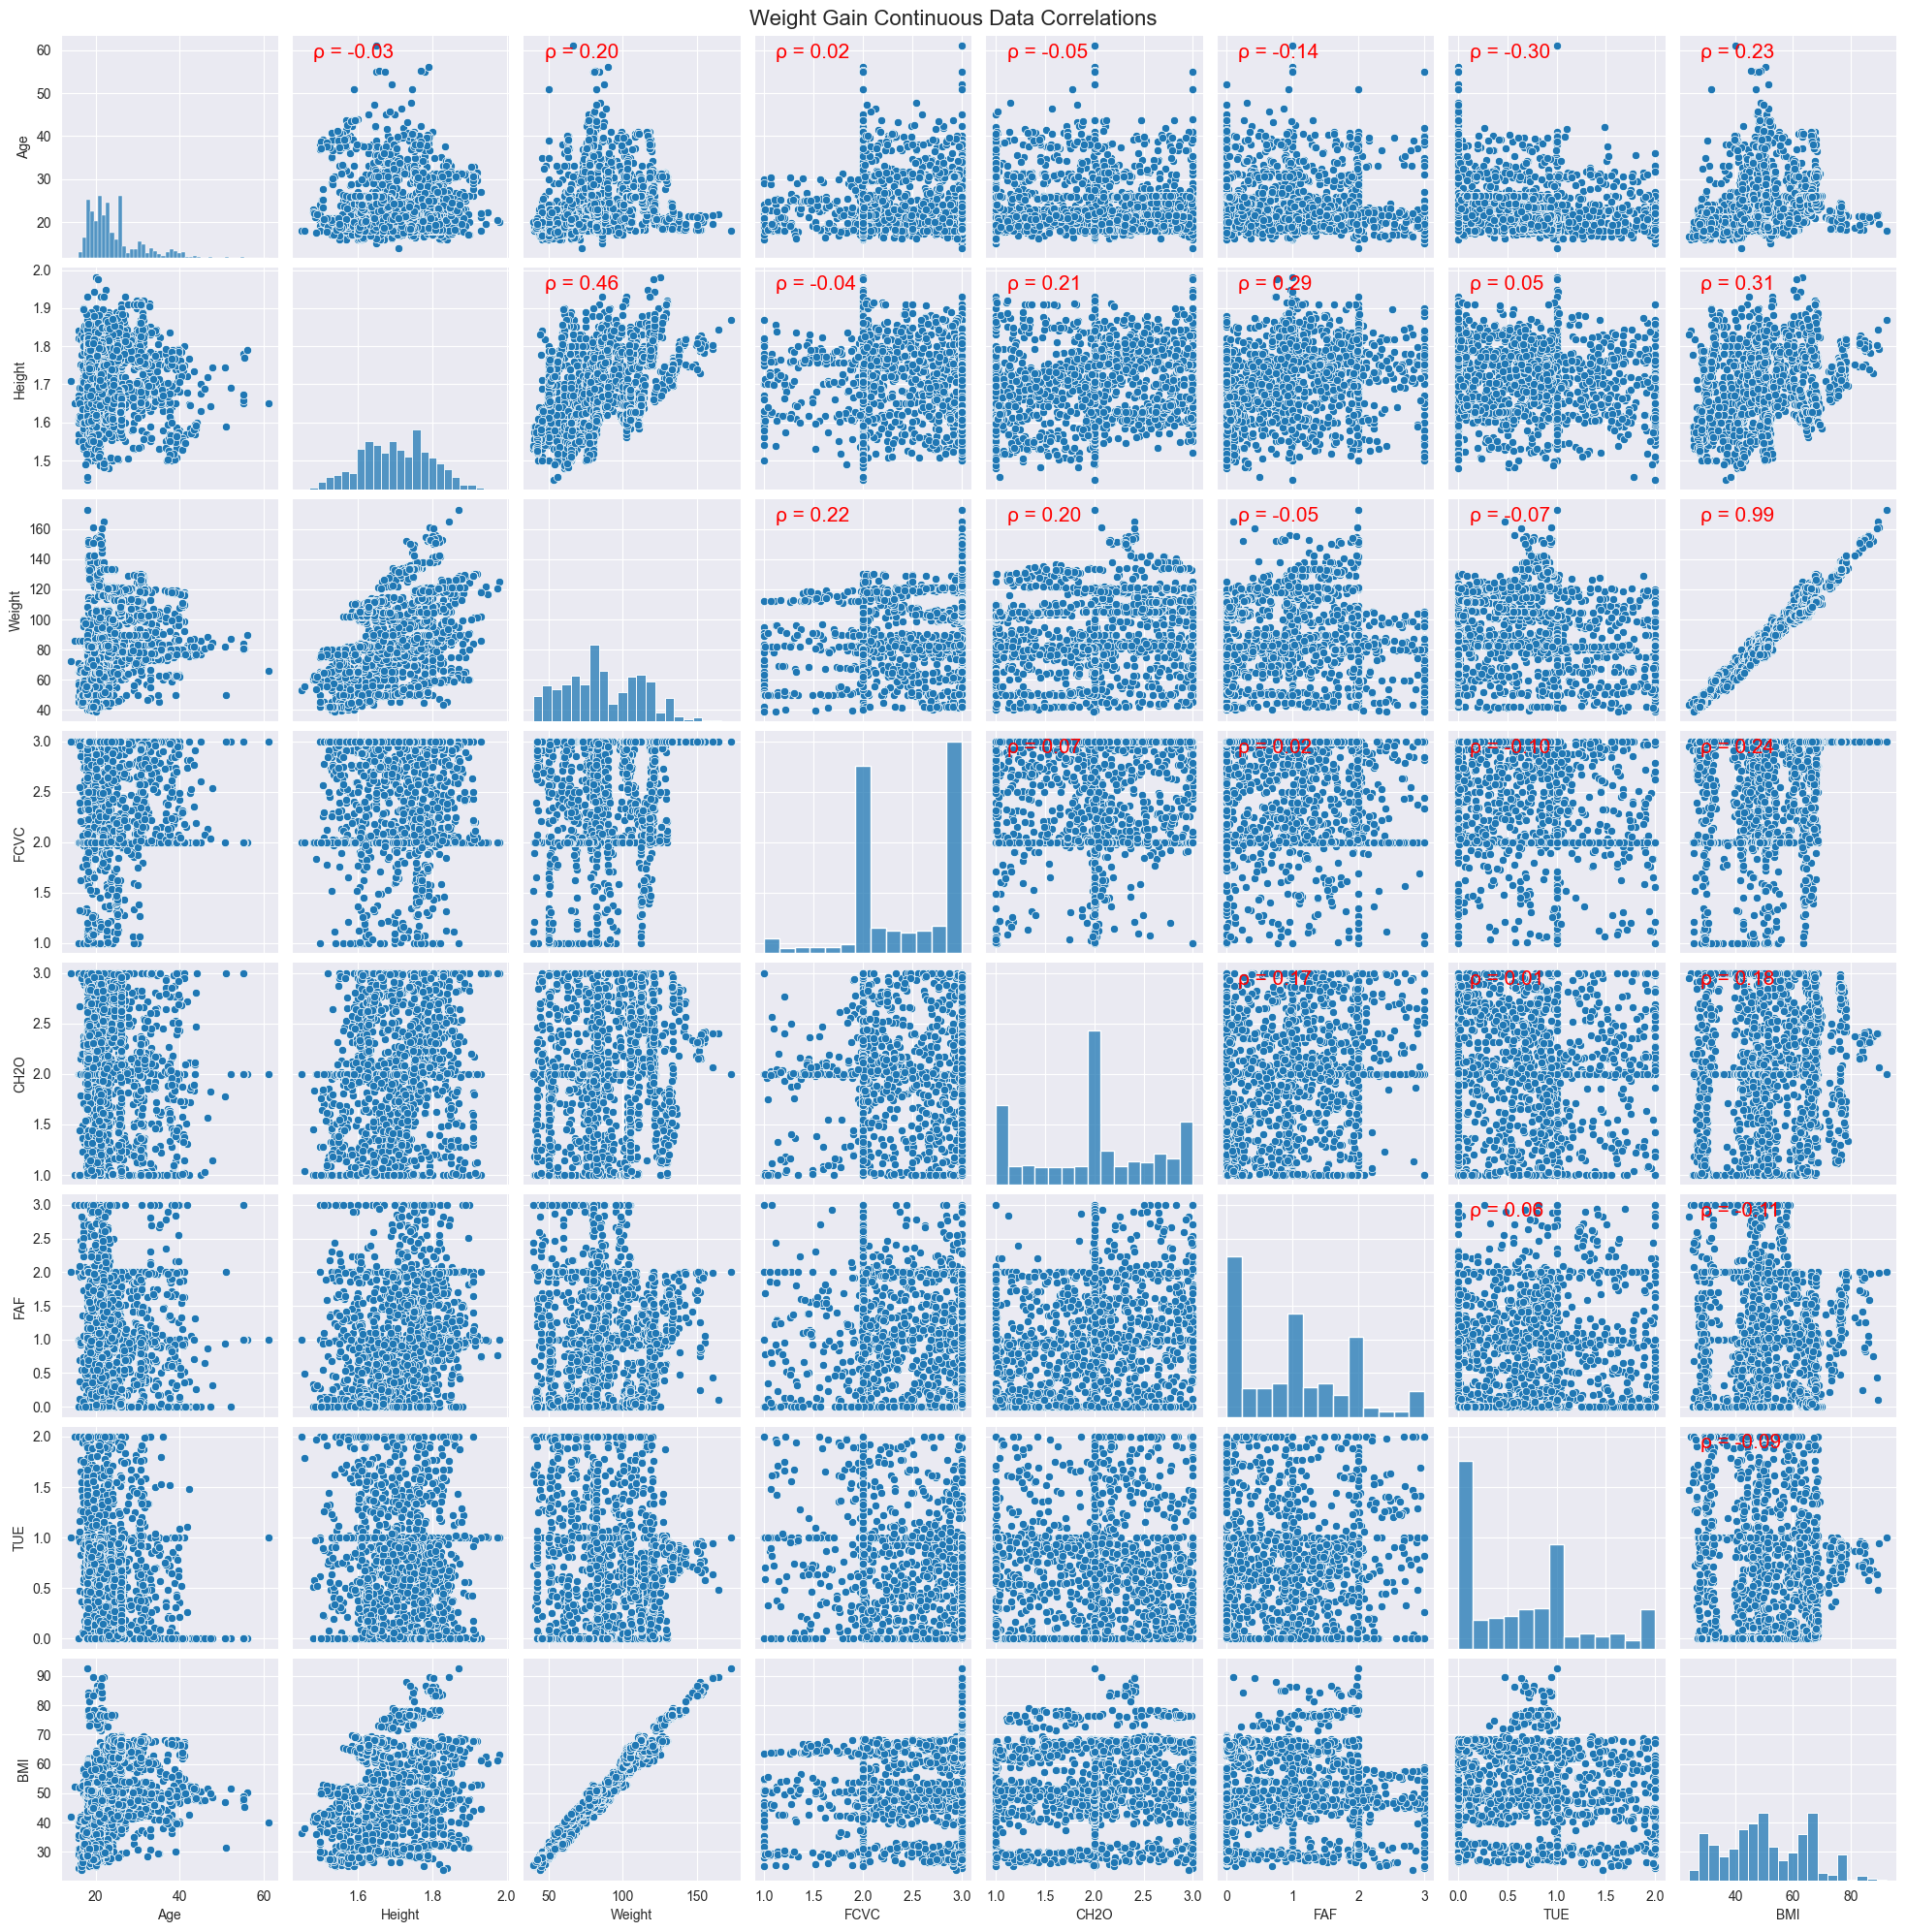

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt


# First plot: Continuous Data Correlations
path = "Plots/CorrelationX1.png"
main = "Weight Gain Continuous Data Correlations"

# Create the pair plot
g = sns.pairplot(df[continuous_vars])
g.map_upper(corrfunc)
plt.suptitle(main, y=1, fontsize=16)
plt.savefig(path)
plt.show()

#### Continuous correlations

Correlations are a little hard to read in the previous code so I made a sepearte plot of numeric correlations.

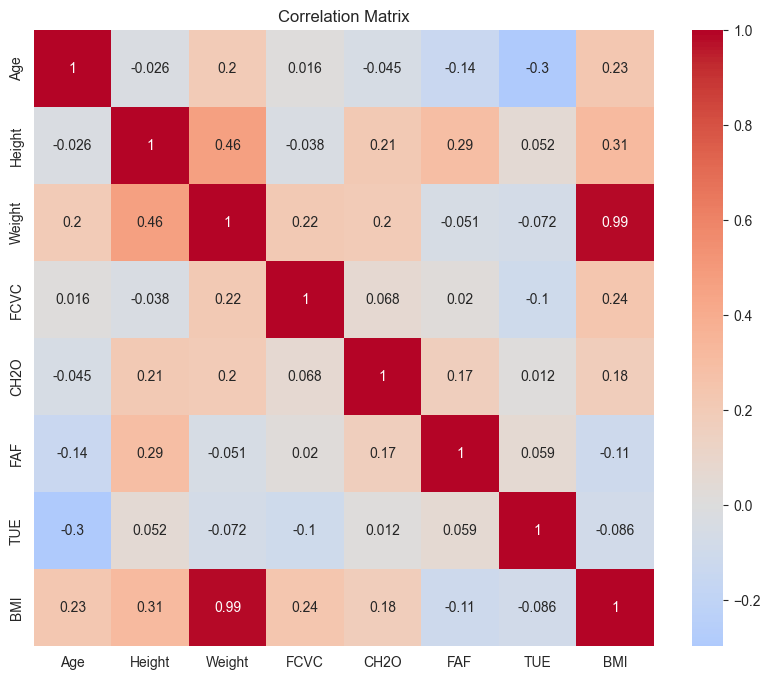

In [42]:
corr_matrix = df[continuous_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.savefig("Plots/CorrelationNumericX1.png")
plt.show()

#### Categorical correlations

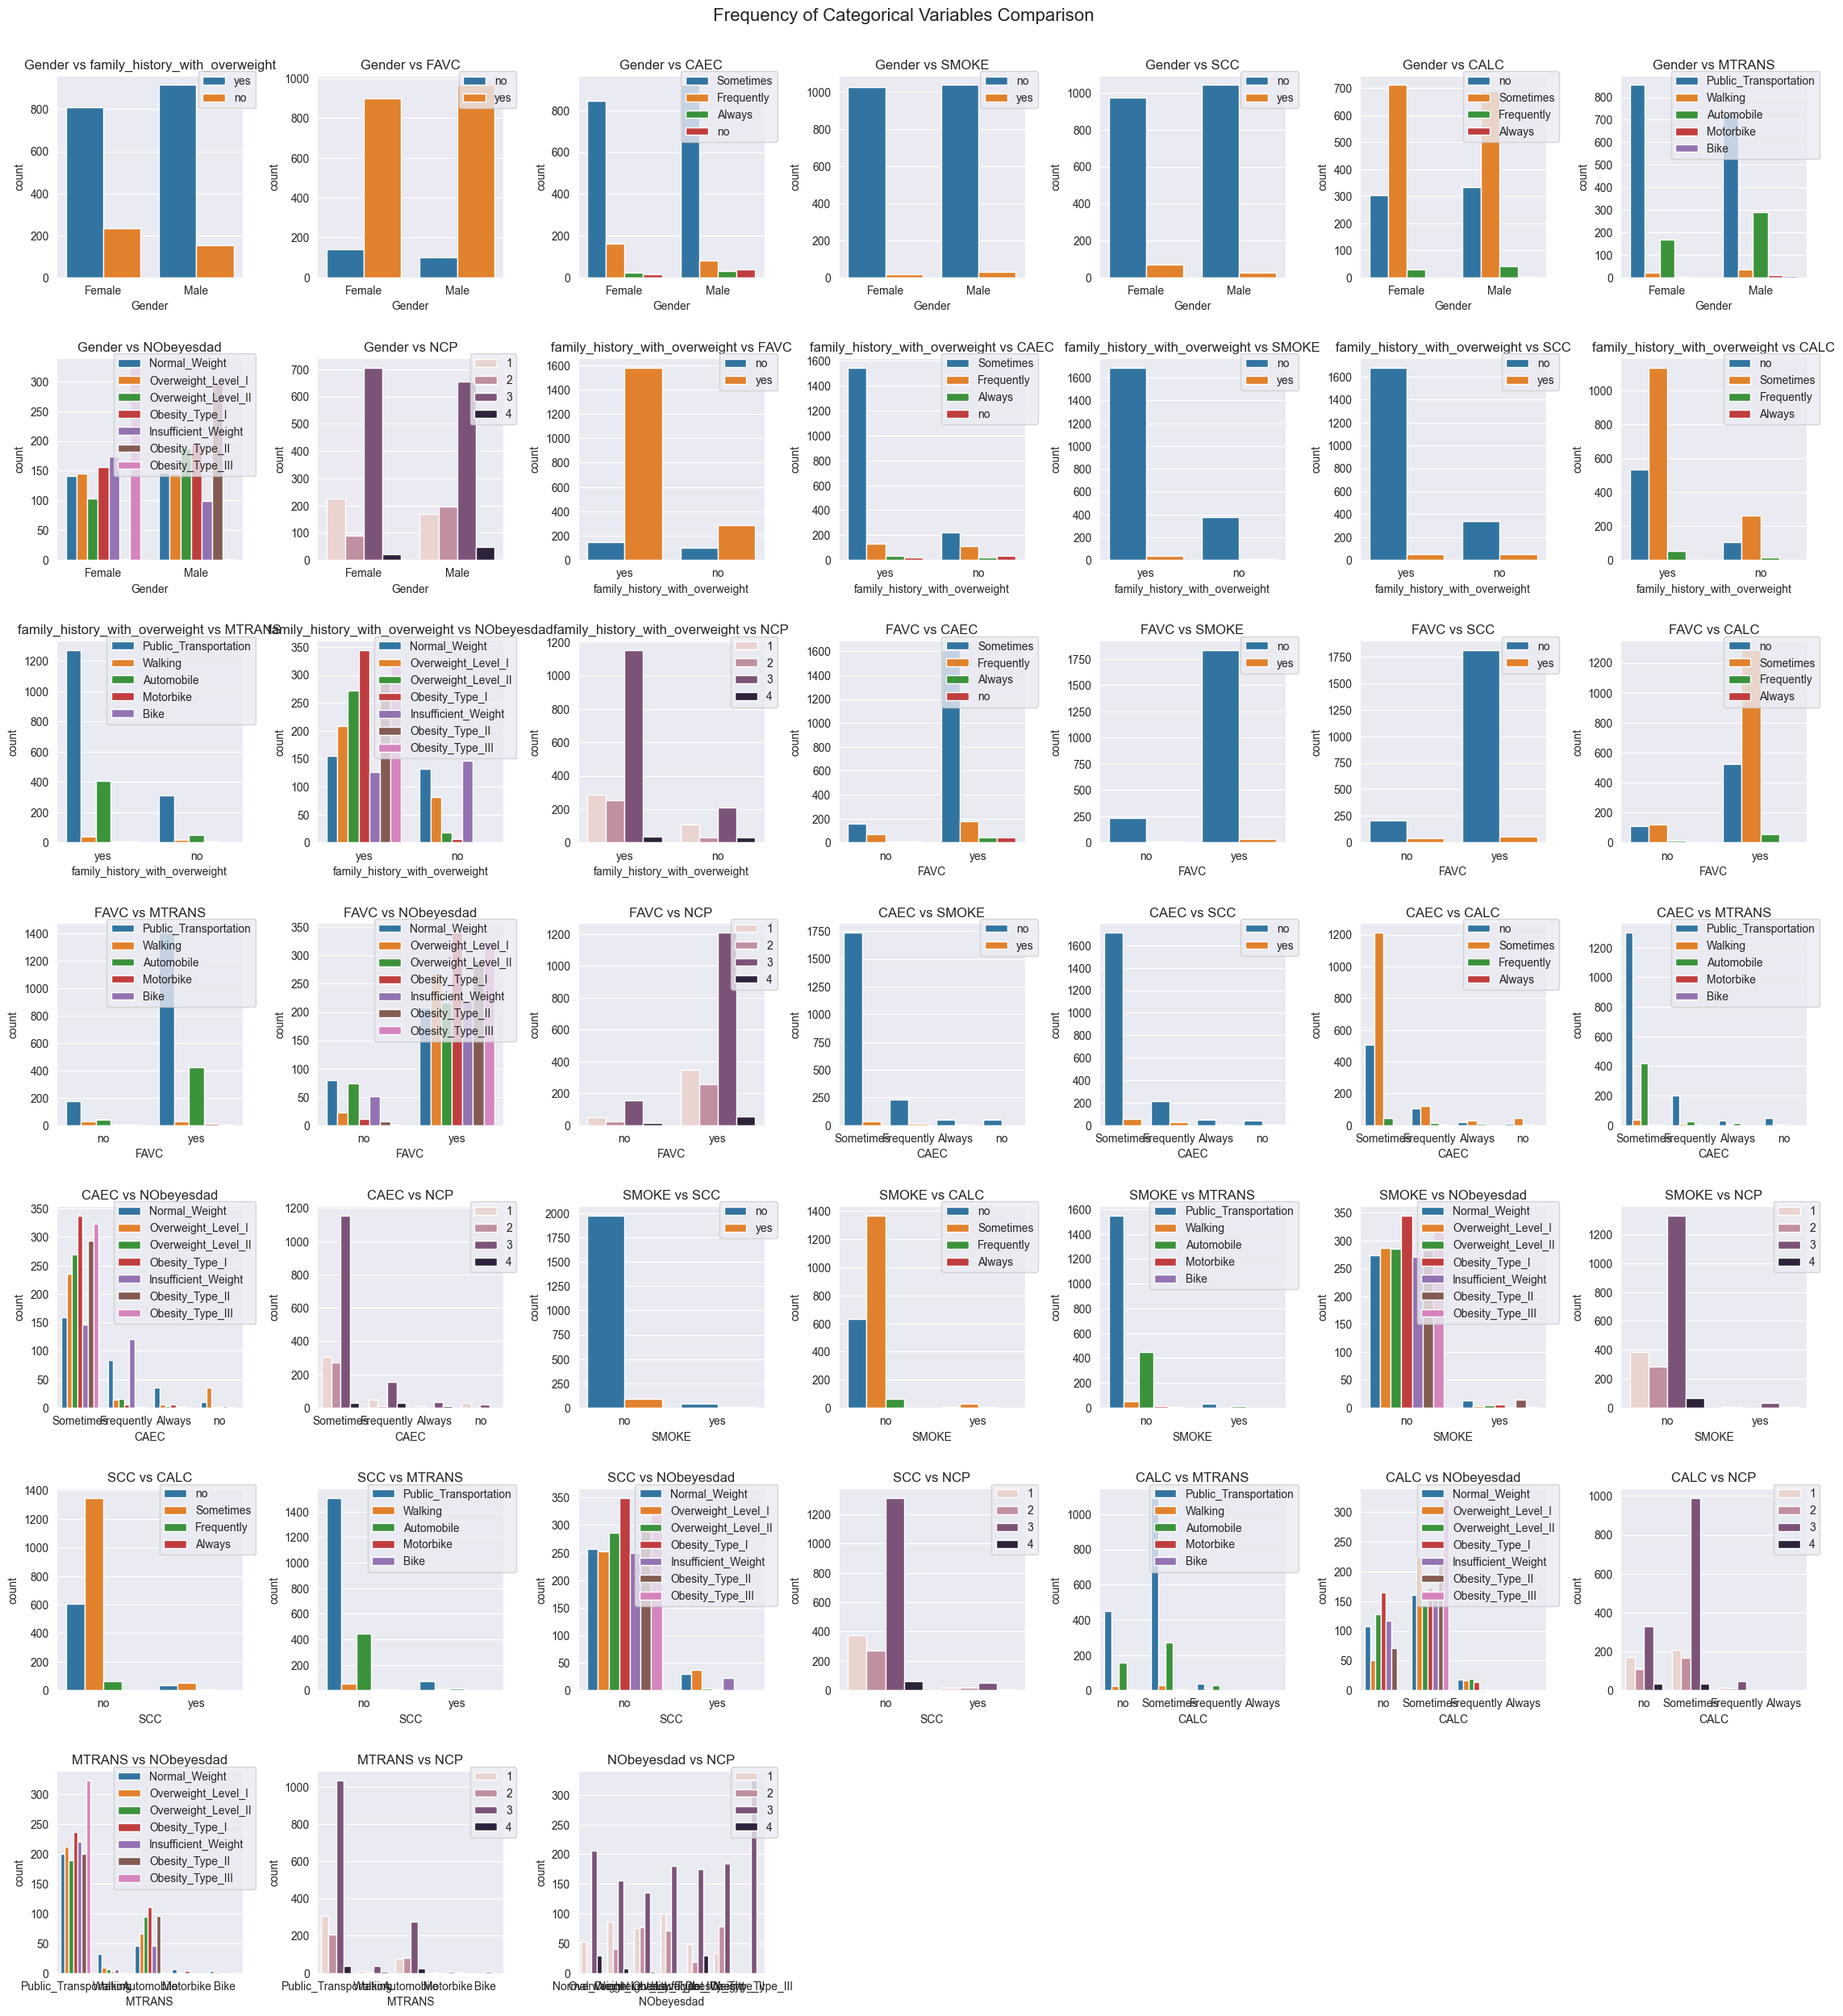

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import math

# Create pairs of categorical variables
pairs = list(itertools.combinations(categorical_vars, 2))

# Calculate the number of rows and columns needed for the grid
num_pairs = len(pairs)
cols = int(math.ceil(math.sqrt(num_pairs)))
rows = int(math.ceil(num_pairs / cols))

# Set up the matplotlib figure with adjusted size
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows), sharex=False, sharey=False)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Iterate over pairs and plot
for ax, (var1, var2) in zip(axes, pairs):
    sns.countplot(data=df, x=var1, hue=var2, ax=ax)
    ax.set_title(f'{var1} vs {var2}')
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

# Remove any unused subplots
for i in range(len(pairs), len(axes)):
    fig.delaxes(axes[i])

# Add a title for the whole figure
fig.suptitle("Frequency of Categorical Variables Comparison", fontsize=16)
plt.subplots_adjust(top=0.95, hspace=0.4, wspace=0.4)
plt.savefig("Plots/CorrelationX2.png")

plt.show()

#### Interactions

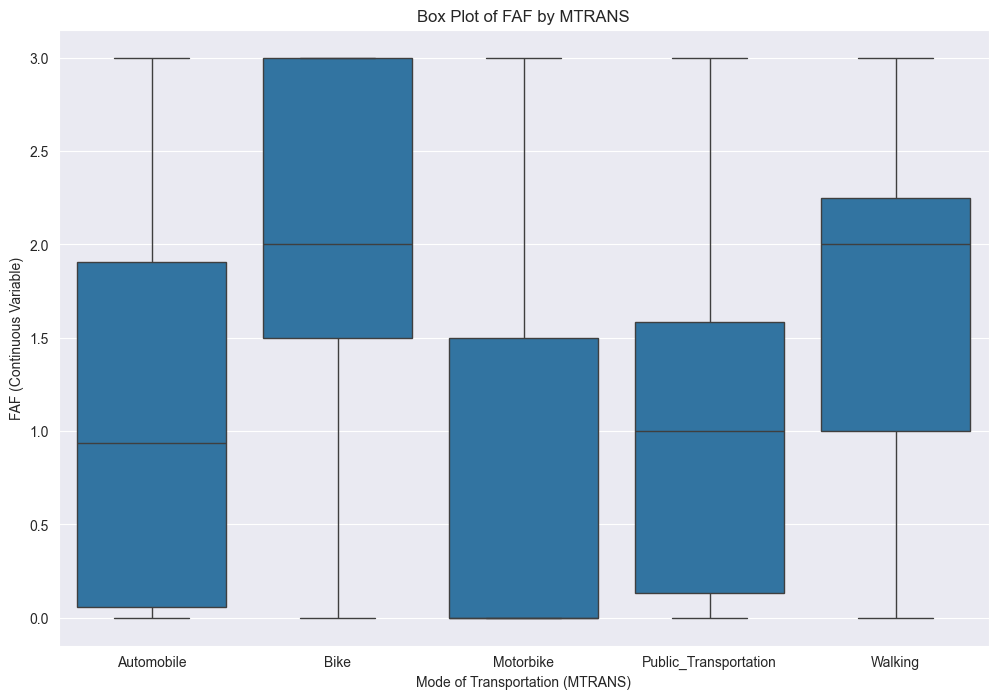

In [44]:
df['MTRANS'] = df['MTRANS'].astype('category')

# Create a box plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='MTRANS', y='FAF')

# Add title and labels
plt.title('Box Plot of FAF by MTRANS')
plt.xlabel('Mode of Transportation (MTRANS)')
plt.ylabel('FAF (Continuous Variable)')
plt.savefig("Plots/Box Plot of FAF by MTRANS.png")

#### Create the model

In [45]:
from scipy import stats
from statsmodels.formula.api import ols
model = ols("BMI~(Gender + Age + FAVC + FCVC + CALC + SCC + FAF + CH2O + CAEC+ TUE)",data=df).fit()
m1 = model
#yes: Gender, Age, FAVC, FCVC, CALC, SCC, FAF, CAEC, TUE

vars_used = ["Gender", "Age", "FAVC", "FCVC", "CALC", "SCC", "FAF", "CAEC", "TUE"]
#no: Height, Weight, NObeyesdad, family_history_with_overweight, smoke, NCP, MTRANS


#### Hypothesis testing

In [46]:
stats.skew(m1.resid)

np.float64(-0.0374093930314435)

In [47]:
stats.kurtosis(m1.resid)

np.float64(-0.008973764744513613)

In [48]:
from statsmodels.stats.anova import anova_lm
anova_lm(m1)

,df,sum_sq,mean_sq,F,PR(>F)
Gender,1.0,1642.780357,1642.780357,12.765964,3.609521e-04
FAVC,1.0,29309.582928,29309.582928,227.763307,6.203279e-49
CALC,3.0,20847.786376,6949.262125,54.002369,1.280235e-33
SCC,1.0,8750.341510,8750.341510,67.998467,2.852245e-16
CAEC,3.0,53611.972064,17870.657355,138.871987,4.565892e-82
Age,1.0,9940.752581,9940.752581,77.249092,3.073627e-18
FCVC,1.0,27385.284025,27385.284025,212.809676,5.548440e-46
FAF,1.0,1189.543213,1189.543213,9.243881,2.392081e-03
CH2O,1.0,6762.125173,6762.125173,52.548137,5.876197e-13
TUE,1.0,237.752144,237.752144,1.847560,1.742137e-01


In [49]:


summary_df = pd.DataFrame({
    'Coefficient': model.params,
    't-value': model.tvalues,
    'p-value': model.pvalues,
})

# summary_df
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BMI   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     88.63
Date:                Sun, 30 Jun 2024   Prob (F-statistic):          1.15e-199
Time:                        19:40:44   Log-Likelihood:                -8114.8
No. Observations:                2111   AIC:                         1.626e+04
Df Residuals:                    2096   BIC:                         1.634e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             11.4394     11.690      0.979      0.328     -11.487      34.366
Gender[T.Male]         2.2805      0.535      4.261      0.000       1.231       3.330
FAVC[T.yes]            6.4383      0.810      7.949      0.000       4.850       8.027
CALC[T.Frequently]    -3.4828     11.459     -0.304      0.761     -25.954      18.989
CALC[T.Sometimes]     -0.5337     11.393     -0.047      0.963     -22.876      21.809
CALC[T.no]            -5.2775     11.392     -0.463      0.643     -27.619      17.064
SCC[T.yes]            -7.0968      1.234     -5.753      0.000      -9.516      -4.678
CAEC[T.Frequently]    -5.6091      1.733     -3.237      0.001      -9.007      -2.211
CAEC[T.Sometimes]      8.4588      1.599      5.291      0.000       5.324      11.594
CAEC[T.no]            -1.4409      2.266     -0.636      0.525      -5.885       3.003
Age                    0.3058      0.042      7.200      0.000       0.222       0.389
FCVC                   6.7764      0.493     13.743      0.000       5.809       7.743
FAF                   -1.2544      0.309     -4.061      0.000      -1.860      -0.649
CH2O                   3.0790      0.423      7.276      0.000       2.249       3.909
TUE                   -0.5956      0.438     -1.359      0.174      -1.455       0.264
==============================================================================
Omnibus:                        0.496   Durbin-Watson:                   0.705
Prob(Omnibus):                  0.781   Jarque-Bera (JB):                0.499
Skew:                          -0.037   Prob(JB):                        0.779
Kurtosis:                       2.991   Cond. No.                     2.35e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

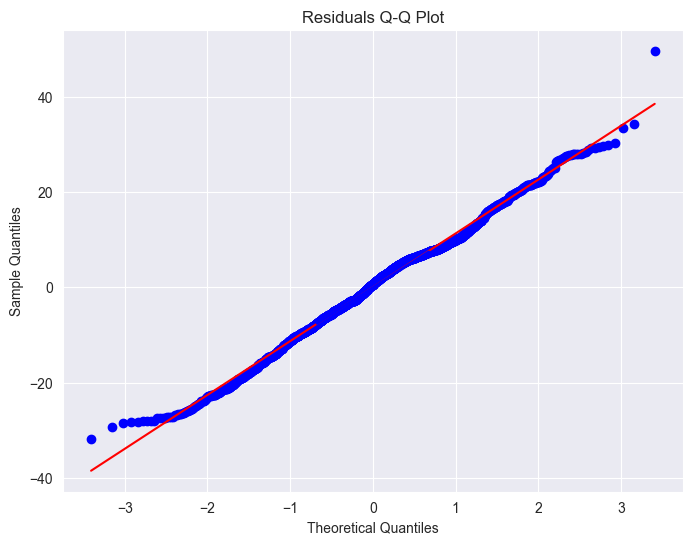

In [50]:
qq_plot(m1, "Plots/QQPlot.png")

#### Check Residuals variance

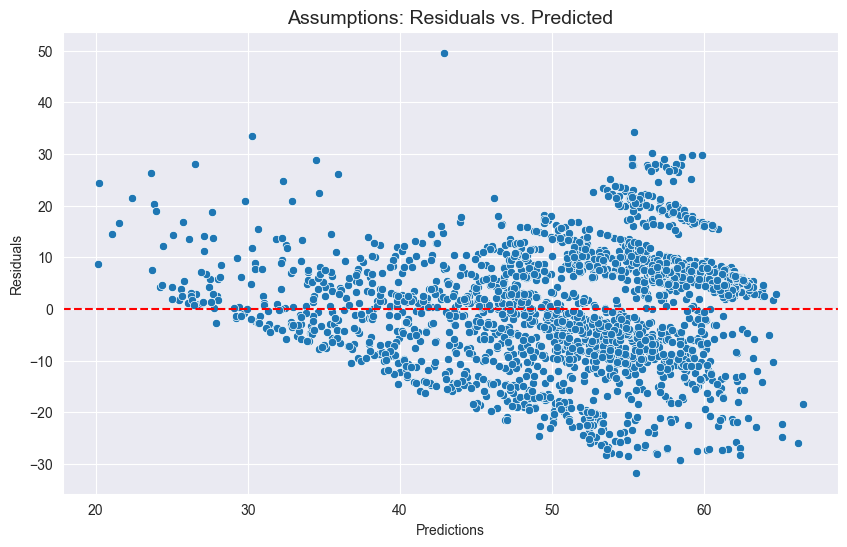

In [51]:
import matplotlib.pyplot as plt

df_plot = pd.DataFrame({"Predictions": m1.fittedvalues,
                        "Residuals": m1.resid})

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_plot, x="Predictions", y="Residuals")
plt.axhline(0, linestyle='--', color='red')
plt.title('Assumptions: Residuals vs. Predicted', fontsize=14, ha='center')
plt.xlabel('Predictions')
plt.ylabel('Residuals')

# Save the plot
plt.savefig('Plots/ResVsPred.png')
plt.show()


In [52]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(m1.resid, model.model.exog)
bp_test_statistic = bp_test[0]
bp_test_p_value = bp_test[1]
bp_test_f_value = bp_test[2]
bp_test_f_p_value = bp_test[3]

print("bp_test_statistic: ", bp_test_statistic,
        "\nbp_test_p_value: ", bp_test_p_value,
        "\nbp_test_f_value: ", bp_test_f_value,
        "\nbp_test_f_p_value: ", bp_test_f_p_value)


bp_test_statistic:  309.2015023781706 
bp_test_p_value:  1.4215370647830662e-57 
bp_test_f_value:  25.692041663611036 
bp_test_f_p_value:  1.5817102763872125e-62


#### Levene

Levene's Test Statistic: 0.8417562869317152
Levene's Test p-value: 0.9973269014373934


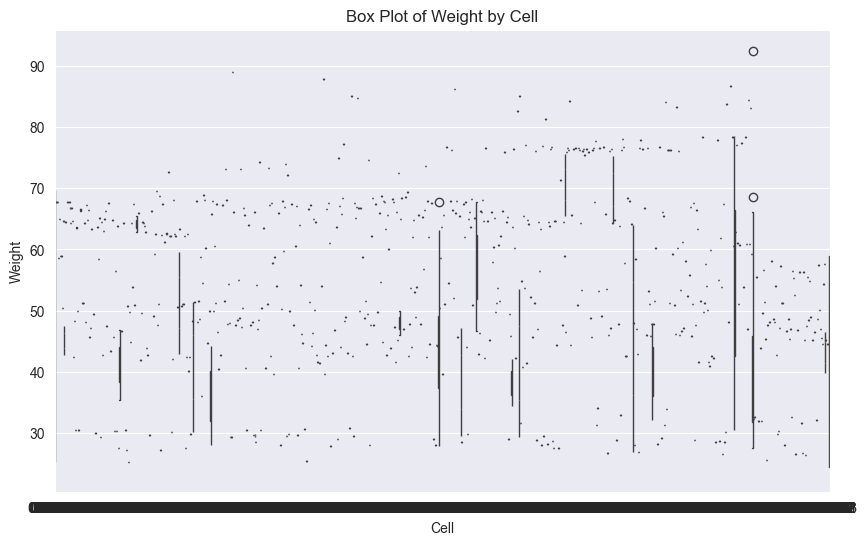

In [53]:
from scipy.stats import levene

stat, p_value = levene(*[group["BMI"].values for name, group in df.groupby("FAF")])

print(f"Levene's Test Statistic: {stat}")
print(f"Levene's Test p-value: {p_value}")

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='FAF', y='BMI')

# Add title and labels
plt.title('Box Plot of Weight by Cell')
plt.xlabel('Cell')
plt.ylabel('Weight')

# Save the plot
plt.savefig("Plots/HIVBP.png")

# Show the plot
plt.show()

In [54]:
for i in vars_used:
    stat, p_value = levene(*[group["BMI"].values for name, group in df.groupby(i)])
    print(f"Levene's Test for: {i}")
    print(f"Levene's Test Statistic: {stat}")
    print(f"Levene's Test p-value: {p_value}")
    print("\n")


Levene's Test for: Gender
Levene's Test Statistic: 125.83629158399619
Levene's Test p-value: 2.0909064849805127e-28


Levene's Test for: Age
Levene's Test Statistic: 0.41088776672010024
Levene's Test p-value: 0.9999999999999999


Levene's Test for: FAVC
Levene's Test Statistic: 79.88210390513238
Levene's Test p-value: 8.466985826413616e-19


Levene's Test for: FCVC
Levene's Test Statistic: 1.4598400231687196
Levene's Test p-value: 7.254544595605213e-10


Levene's Test for: CALC
Levene's Test Statistic: 65.01295315098778
Levene's Test p-value: 3.3500393038452302e-40


Levene's Test for: SCC
Levene's Test Statistic: 54.798982370135256
Levene's Test p-value: 1.918694892276006e-13


Levene's Test for: FAF
Levene's Test Statistic: 0.8417562869317152
Levene's Test p-value: 0.9973269014373934


Levene's Test for: CAEC
Levene's Test Statistic: 53.49580195412248
Levene's Test p-value: 2.5445270543087357e-33


Levene's Test for: TUE
Levene's Test Statistic: 0.8850789561656535
Levene's Test p-val

In [55]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test
ljung_box_result = acorr_ljungbox(m1.resid, lags=[1], return_df=True)
print(ljung_box_result)

      lb_stat      lb_pvalue
1  885.343597  1.506522e-194


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\smuuu\\DataspellProjects\\HDS_502\\A1M1\\A1M1\\Plots\\ResVBigBin.png'

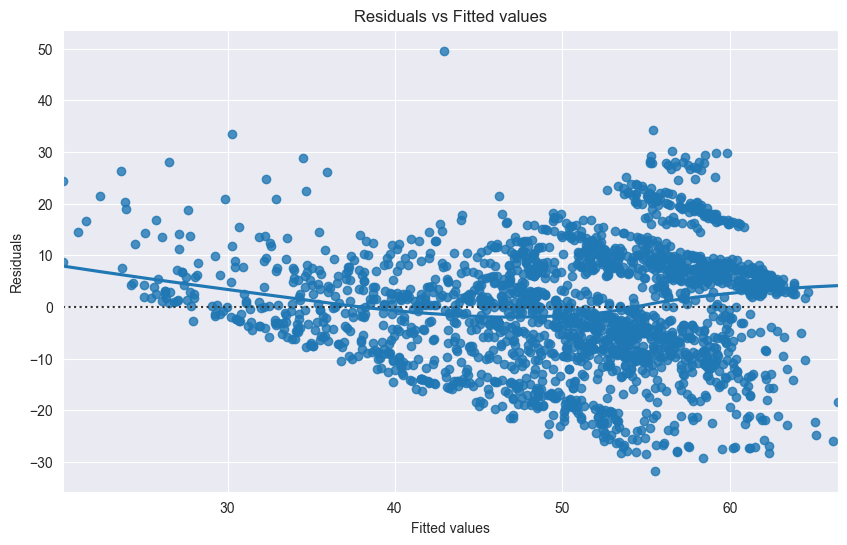

In [56]:
import os

# Simulate residuals (residuals from the fitted model)
residuals = model.resid

# Plot residuals vs fitted values
ptype = "ResVpred"
ver = "version"  # Define your version variable
part = "part"    # Define your part variable
mdl = "model"    # Define your model name
loc = os.path.join("A1M1/Plots", "ResVBigBin.png")

plt.figure(figsize=(10, 6))
sns.residplot(x=model.fittedvalues, y=residuals, lowess=True)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.savefig(loc)


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

# Perform Tukey's HSD test for pairwise comparisons
tukey = pairwise_tukeyhsd(endog=df['BMI'],
                          groups=df['FAVC'].astype(str) + " : " + df['CAEC'].astype(str),
                          alpha=0.05)

# Print Tukey's HSD results
print(tukey)

# Plot and save the Tukey HSD results
plt.figure(figsize=(10, 6))
tukey.plot_simultaneous()
plt.title('Tukey HSD Test for Pairwise Comparisons')
plt.xlabel('Mean Difference')
plt.grid(True)

# Ensure the directory exists
output_dir = "A1M1/Plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

plt.savefig(os.path.join(output_dir, "HIVPWC.png"))

In [ ]:
m2 = ols("BMI~(Gender + Age + FAVC + FCVC + CALC + SCC + FAF + CH2O + CAEC + TUE + FAVC*CAEC)", data=df).fit()

# Summary of the model
model_summary = m2.summary()
print(model_summary)

# Save the summary to a LaTeX file
with open("A1M1/Tables/ModelSummaryAll.tex", "w") as f:
    f.write(model_summary.as_latex())

#### Effect Size

In [ ]:
import pingouin as pg

# Calculate effect sizes

# Prepare data for effect size calculation
df['Gender'] = df['Gender'].astype('category').cat.codes
df['FAVC'] = df['FAVC'].astype('category').cat.codes
df['CALC'] = df['CALC'].astype('category').cat.codes
df['SCC'] = df['SCC'].astype('category').cat.codes
df['CAEC'] = df['CAEC'].astype('category').cat.codes

# Create interaction term manually
df['FAVC_CAEC'] = df['FAVC'] * df['CAEC']

# List of predictor variables including interaction term
predictors = ['Gender', 'Age', 'FAVC', 'FCVC', 'CALC', 'SCC', 'FAF', 'CH2O', 'CAEC', 'TUE', 'FAVC_CAEC']

# Calculate effect sizes
effect_sizes = pg.linear_regression(df[predictors], df['BMI'])
print(effect_sizes)

# Save the effect sizes to a LaTeX file
with open("A1M1/Tables/EffectSize.tex", "w") as f:
    f.write(effect_sizes.to_latex())

In [ ]:
# Fit another model (for comparison)
# Compare models using ANOVA
anova_results = sm.stats.anova_lm(m1, m2)
print(anova_results)

# Save the ANOVA comparison to a LaTeX file
with open("A1M1/Tables/ModelCompare.tex", "w") as f:
    f.write(anova_results.to_latex())